Based on a post @ [Towards Data Science](https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0).

In [1]:
from IPython.display import Image

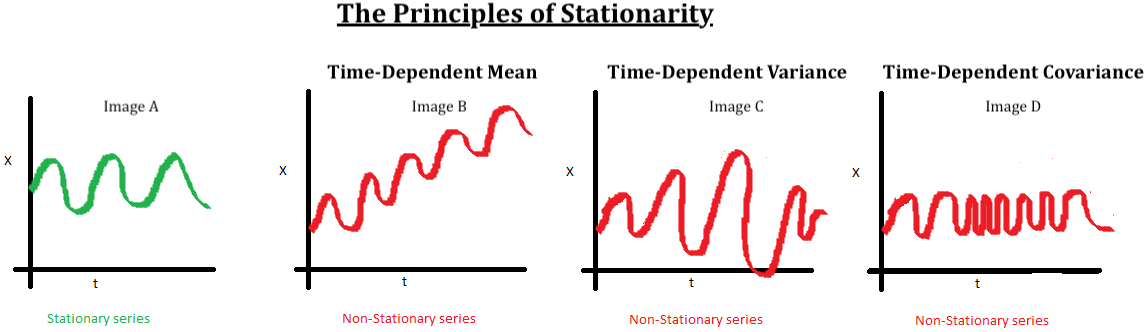

In [2]:
Image('./IMG/principles-of-stationarity.png')

## Achieving Stationarity with Time Series Data

"Most time series models work under the assumption that the underlying data is <u>stationary</u>, that is <u>the mean, variance, and covariance are not time-dependent</u>".

- "More likely than not your time series will not be stationary which means that you will have to identify the trends present in your series and manipulate the data to become stationary".

- "After the trends are removed you can apply advanced modeling techniques while maintaining the valuable knowledge of the separated trends, which will be used later".

"There are a few options available to data scientists when it comes to removing trends: 1) a transformation of the data,2) removing a rolling statistic, and 3) [differencing](https://machinelearningmastery.com/time-series-trends-in-python/)."

- "I’ll cover these methods below using historical S&P 500 index price data obtained from the [UniBit](https://unibit.ai/) API below".

- For this notebook, the data was obtained from [this link](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC).
    - Time period: 2019-01-14 to 2020-01-14.
    - Show: Historical prices.
    - Frequency: daily.

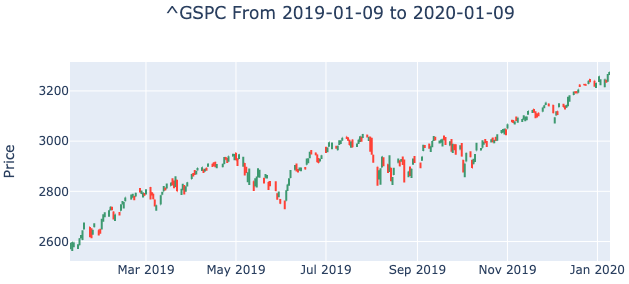

In [3]:
Image('./IMG/s-and-p-history.png')

### 1) Transformation

"I organized my price data in a pandas dataframe. The index is set to the date column and the dates are sorted in ascending order".

In [12]:
import numpy as np
import pandas as pd

In [11]:
data = pd.read_csv('./^GSPC.csv')

data['Date'] = pd.to_datetime(data.Date)
data.columns = [col.replace(' ', '_').lower() for col in data.columns]

data = data.set_index('date').sort_index()
data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2019-01-14,2580.310059,2589.320068,2570.409912,2582.610107,2582.610107,3664450000
2019-01-15,2585.100098,2613.080078,2585.100098,2610.300049,2610.300049,3572330000
2019-01-16,2614.750000,2625.760010,2612.679932,2616.100098,2616.100098,3863770000
2019-01-17,2609.280029,2645.060059,2606.360107,2635.959961,2635.959961,3772270000
2019-01-18,2651.270020,2675.469971,2647.580078,2670.709961,2670.709961,3986730000


Creating new columns for transformations (log, square root, cubed root) of the Adj. Close column:

In [13]:
data['adj_close_log'] = np.log(data['adj_close'])

data['adj_close_sqrt'] = np.sqrt(data['adj_close'])

data['adj_close_cbrt'] = np.cbrt(data['adj_close'])

"No single transformation method will universally turn all time series stationary, you will have to test them for yourself. The visualization of the logarithmic transformation is below".

- "This particular transformation didn’t fully accomplish stationarity for this series. The range of the prices changed drastically and the upward trend of the series has been reduced which is a good first step. Logarithmic functions are inverses of exponential functions with the same base".

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

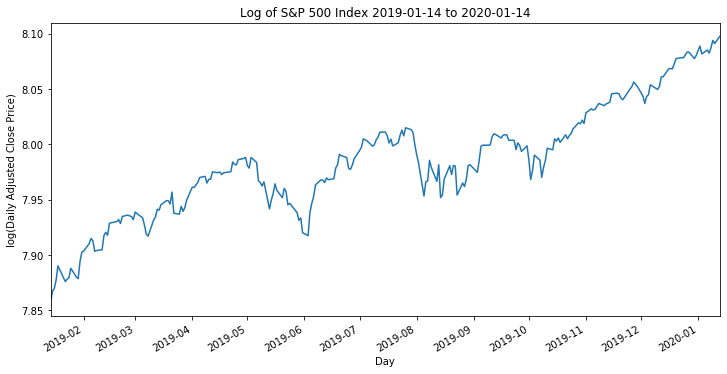

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

data.adj_close_log.plot(ax=ax)

ax.set_title('Log of S&P 500 Index 2019-01-14 to 2020-01-14')
ax.set_xlabel('Day')
ax.set_ylabel('log(Daily Adjusted Close Price)')

plt.show()

### 2) Rolling Means

"You can subtract the rolling mean from a time series".

- "This works especially well when the mean is time dependent".

- "A [rolling mean](https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/) is <u>the mean of the previous $x$ number of observations in the series</u>, where the time between each observation is consistent".

- "You have to decide which time window works best for your data".
    - "Because I am using daily trading data I selected a window of $20$ because that is how many trading days there are in a month, although this is not a universal window for financial data".

- "`pandas` `.rolling()` method can be used to calculate this rolling mean". More [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).


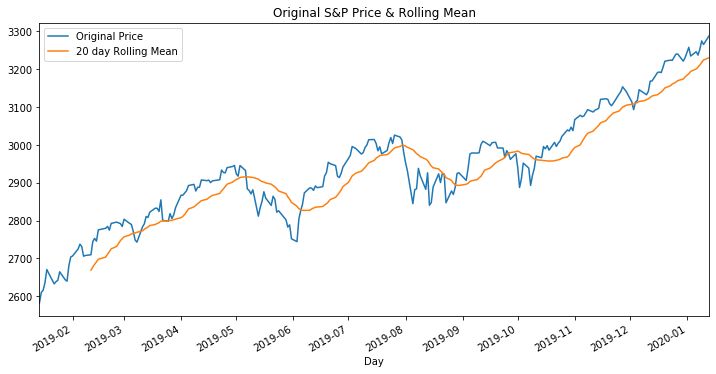

In [34]:
fig, ax = plt.subplots(figsize=(12,6))

data.adj_close.plot(ax=ax, label='Original Price')
data.adj_close.rolling(window=20).mean().plot(ax=ax, label='20 day Rolling Mean')

ax.set_title('Original S&P Price & Rolling Mean')
ax.set_xlabel('Day')
ax.legend()

plt.show()

"I created a new array of the rolling mean subtracted from the original closing price column and charted it below to see if this improved stationarity in the series".


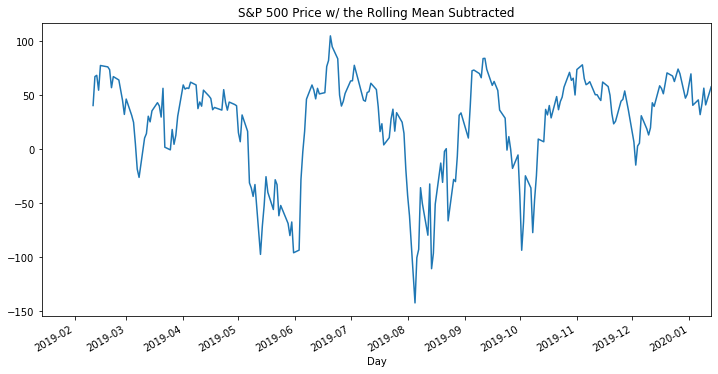

In [32]:
fig, ax = plt.subplots(figsize=(12,6))

(data.adj_close - data.adj_close.rolling(window=20).mean()).plot(ax=ax)

ax.set_title('S&P 500 Price w/ the Rolling Mean Subtracted')
ax.set_xlabel('Day')

plt.show()

"This series appears to be much closer to stationarity".

- "The upward trend is virtually gone but the variance is still apparent".
    - "For financial data, it is perfectly reasonable to remove [the weighted rolling mean](https://www.investopedia.com/ask/answers/071414/whats-difference-between-moving-average-and-weighted-moving-average.asp) from the original data as well".
    - "The weighted rolling mean assigns a greater weight to more recent observations".
        - "In Python this is calculated with the `.ewm()` method, for my data the code is as follows" (more [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)):

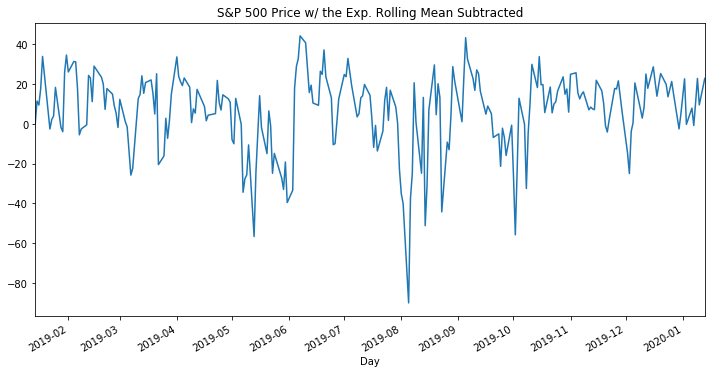

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

(data.adj_close - data.adj_close.ewm(halflife=2).mean()).plot(ax=ax)

ax.set_title('S&P 500 Price w/ the Exp. Rolling Mean Subtracted')
ax.set_xlabel('Day')

plt.show()

### 3) Differencing

"This is the process subtracting the value of one observation with the value of another observation x number of periods ago, where x is the time period lag".

- "For instance, in the S&P 500 example, if the lag is one year then the differencing value on January 1, 2020 is equal to the actual price observed on January 1, 2020 minus the value observed on January 1, 2019".

- "The `pandas` library’s `.diff(periods=x)` method can be used to calculate an array of differentiating values". More [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html).
    - "The period parameter denotes the lag used".
    - "My values are in daily increments which means a lag of 365 is equal to a year and a lag of 1 is equal to a day".


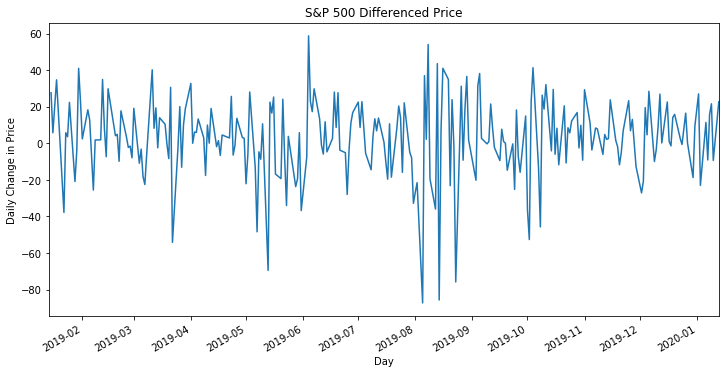

In [39]:
fig, ax = plt.subplots(figsize=(12,6))

data.adj_close.diff(periods=1).plot(ax=ax)

ax.set_title('S&P 500 Differenced Price')
ax.set_xlabel('Day')
ax.set_ylabel('Daily Change in Price')

plt.show()

"The differencing also removed the upward trend of the time series although the variance is still time dependent".